# Basics of Markov chains

In this notebook we review basics tasks related to Markov chains:
* parameter estimation
* finding marginal probabilities
* finding the most probable outcome

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import string

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I.  Estimating parameters of homogenus Markov chain

<img src = 'illustrations/homogenous-markov-chain.pdf' width=100%>

Recall that in order to estimate initial probabilities $\boldsymbol{\beta}[\cdot]$ and transition probabilities $\boldsymbol{\alpha}[\cdot,\cdot]$ we need to count starting letters and bigrams.
After that we can use maximum likelihood estimates

\begin{align*}
\beta[u_1]  &= \frac{k(\bullet,u_1)}{k(\bullet,*)}\\
\alpha[u_1 u_2] &= \frac{k(u_1,u_2)}{k(u_1,*)}
\end{align*}

or Laplace smoothing estimates

\begin{align*}
\beta[u_1]  &= \frac{k(\bullet,u_1)+c}{k(\bullet,*)+mc}\\
\alpha[u_1 u_2] &= \frac{k(u_1,u_2)+c}{k(u_1,*)+mc}
\end{align*}

where $\bullet$ denotes the start of the string, $c\geq 0$ is the Laplace smoothing constant and $m$ is the total number of characters. 

### Preprocessing

As a practical engineering trick we convert all character to lower case and map all values outside the range `0-9a-z` to the symbol `?`, which will represent all characters we do not want to treat. For obvios reasons, this approach is valid only for English tests.

In [4]:
df = pd.read_csv('data/eng_training_set.csv', header=None, names=['words'])
old = head(df).copy()
df['words'] = df['words'].str.lower().str.replace('[^0-9a-z]','?')
mdisplay([old, head(df)],['Initial data', 'Processed data'])

Initial data Processed data 
 
 
 words 
 
 
 
 
 friendship 
 
 
 guess 
 
 
 accounts 
 
 
 it's 
 
 
 me 
 
 
 
 
 
 words 
 
 
 
 
 friendship 
 
 
 guess 
 
 
 accounts 
 
 
 it?s 
 
 
 me

### Counts of starting letters

In [14]:
df['words'].str.lower().str[0].value_counts()

t    164
a    101
i     92
w     72
s     63
o     51
b     48
f     42
c     41
m     37
p     36
g     31
h     31
n     29
d     27
e     25
r     25
l     22
y     19
u     16
k     11
j      9
1      2
v      2
2      2
7      1
q      1
Name: words, dtype: int64

In [15]:
start_counts = (DataFrame(df['words'].str.lower()
                          .str[0].value_counts())
                .reset_index()
                .rename(columns = {'index': 'u1', 'words': 'count'})
                .set_index(['u1']))
display(head(start_counts))

,count
u1,
t,164
a,101
i,92
w,72
s,63


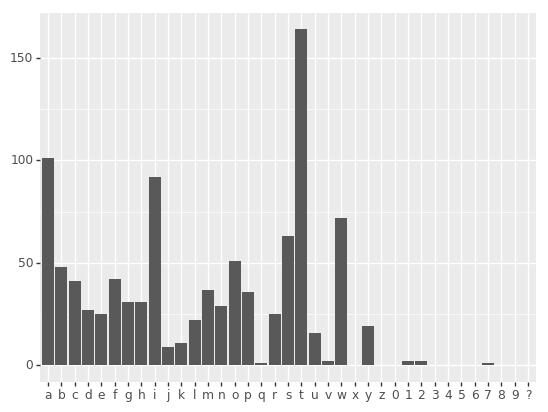

<ggplot: (-9223372029311784409)>

In [16]:
LetterType = CategoricalDtype(list(string.ascii_lowercase) + list(string.digits) + ['?'], ordered = True)

p = ggplot(start_counts.reset_index().assign(u1 = lambda df: df['u1'].astype(LetterType)))
p = p + geom_col(aes(x = 'u1', y = 'count'))
p + scale_x_discrete(name = '', drop = False) + scale_y_continuous(name = '')

### Count bigrams

In [17]:
def ngrams(text:str, n:int=2) -> List[str]:
    '''
    Returns a list of ngrams for the text 
    
    Inspired by http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
    '''
    
    return [''.join(x) for x in zip(*[text[i:] for i in range(n)])]

In [18]:
print(ngrams('abcdef', 1))
print(ngrams('abcdef', 2))
print(ngrams('abcdef', 3))

['a', 'b', 'c', 'd', 'e', 'f']
['ab', 'bc', 'cd', 'de', 'ef']
['abc', 'bcd', 'cde', 'def']


In [24]:
Series(df.loc[1:5,'words'].str.lower().apply(ngrams).sum()).value_counts()

it    1
ac    1
cc    1
?s    1
nt    1
ie    1
da    1
ue    1
el    1
un    1
co    1
me    1
ts    1
ni    1
gu    1
an    1
es    1
ou    1
t?    1
ss    1
la    1
dtype: int64

In [25]:
bigram_counts = (DataFrame(
                    Series(
                        df['words'].str.lower()
                        .apply(ngrams).sum())
                    .value_counts())
                 .rename(columns = {0: 'count'})
                 .assign(u1 = lambda df: Series(df.index.values).str[0].to_list())
                 .assign(u2 = lambda df: Series(df.index.values).str[1].to_list())
                 .set_index(['u1', 'u2'])
                 )
display(head(bigram_counts))                

,,count
u1,u2,
t,h,126
h,e,86
i,n,75
a,n,63
r,e,61


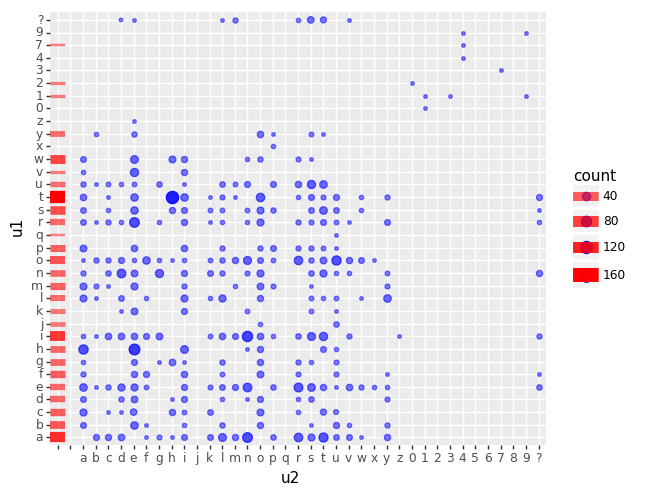

<ggplot: (-9223372029311421033)>

In [26]:
LetterType2 = CategoricalDtype([' ', '  '] + list(string.ascii_lowercase) + list(string.digits) + ['?'], ordered = True)

p = ggplot(bigram_counts
           .reset_index()
           .assign(u1 = lambda df: df['u1'].astype(LetterType2))
           .assign(u2 = lambda df: df['u2'].astype(LetterType2)))
p = p + geom_point(aes(x = 'u2', y = 'u1', size = 'count',  alpha = 'count'), color =  'blue')
p = p + geom_rug(aes(y='u1', size='count', alpha = 'count'), color = 'red', data = start_counts.reset_index())
p = p + coord_fixed(ratio = 1)
p = p + scale_x_discrete(drop=False)
p = p + scale_alpha(range=(0.5, 1)) 
p = p + scale_size(range=(1, 5))
display(p)

### Parameter estimates with Laplace smoothing 

It is common to take $c=1$ in Laplace smoothing.
Note that counts do not contain entries for missing symbols:
* We must insert missing zeroes or we get $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$ with wrong shapes.
* We must insert missing zeroes before Laplace smoothing or we get wrong values. 

In [30]:
start_counts.reindex(LetterType.categories, fill_value = 0) + 1

,count
a,102
b,49
c,42
d,28
e,26
f,43
g,32
h,32
i,93
j,10


In [31]:
beta = ((start_counts.reindex(LetterType.categories, fill_value=0) + 1)
        .rename(columns = {'count': 'pr'})
        .assign(pr = lambda df: df['pr']/df['pr'].sum())
        )

In [32]:
head(bigram_counts)

,,count
u1,u2,
t,h,126
h,e,86
i,n,75
a,n,63
r,e,61


In [33]:
# Index without gaps
midx = pd.MultiIndex.from_product([LetterType.categories.values]*2, names = ['u1', 'u2'])

alpha = (bigram_counts.reindex(midx, fill_value=0).groupby(['u1'])
         .apply(lambda df: df.assign(pr = lambda ddf: (ddf['count']+1)/(ddf['count']+1).sum()))
         [['pr']]) 

mdisplay([head(beta.reset_index()), head(alpha.reset_index())], ['beta', 'alpha'])

beta alpha 
 
 
 index 
 pr 
 
 
 
 
 a 
 0.098361 
 
 
 b 
 0.047252 
 
 
 c 
 0.040501 
 
 
 d 
 0.027001 
 
 
 e 
 0.025072 
 
 
 
 
 
 u1 
 u2 
 pr 
 
 
 
 
 a 
 a 
 0.002825 
 
 
 a 
 b 
 0.033898 
 
 
 a 
 c 
 0.036723 
 
 
 a 
 d 
 0.045198 
 
 
 a 
 e 
 0.002825

We must convert $\boldsymbol{\alpha}$ to matrix form for convenience and efficiency. 

In [35]:
alpha.unstack('u2')

pr                                                              \
u2         0         1         2         3         4         5         6   
u1                                                                         
0   0.026316  0.052632  0.026316  0.026316  0.026316  0.026316  0.026316   
1   0.025000  0.050000  0.025000  0.050000  0.025000  0.025000  0.025000   
2   0.052632  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
3   0.026316  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
4   0.026316  0.026316  0.026316  0.026316  0.052632  0.026316  0.026316   
5   0.027027  0.027027  0.027027  0.027027  0.027027  0.027027  0.027027   
6   0.027027  0.027027  0.027027  0.027027  0.027027  0.027027  0.027027   
7   0.026316  0.026316  0.026316  0.026316  0.052632  0.026316  0.026316   
8   0.027027  0.027027  0.027027  0.027027  0.027027  0.027027  0.027027   
9   0.025641  0.025641  0.025641  0.025641  0.051282  0.025641  0.025641   
?   0.013333  0.013333  0.013333  0.013333  0.013333  0.013333  0.013333   
a   0.002825  0.002825  0.002825  0.002825  0.002825  0.002825  0.002825   
b   0.008850  0.008850  0.008850  0.008850  0.008850  0.008850  0.008850   
c   0.007407  0.007407  0.007407  0.007407  0.007407  0.007407  0.007407   
d   0.009346  0.009346  0.009346  0.009346  0.009346  0.009346  0.009346   
e   0.003115  0.003115  0.003115  0.003115  0.003115  0.003115  0.003115   
f   0.009259  0.009259  0.009259  0.009259  0.009259  0.009259  0.009259   
g   0.010417  0.010417  0.010417  0.010417  0.010417  0.010417  0.010417   
h   0.004329  0.004329  0.004329  0.004329  0.004329  0.004329  0.004329   
i   0.003155  0.003155  0.003155  0.003155  0.003155  0.003155  0.003155   
j   0.021739  0.021739  0.021739  0.021739  0.021739  0.021739  0.021739   
k   0.013889  0.013889  0.013889  0.013889  0.013889  0.013889  0.013889   
l   0.006289  0.006289  0.006289  0.006289  0.006289  0.006289  0.006289   
m   0.008772  0.008772  0.008772  0.008772  0.008772  0.008772  0.008772   
n   0.004149  0.004149  0.004149  0.004149  0.004149  0.004149  0.004149   
o   0.003344  0.003344  0.003344  0.003344  0.003344  0.003344  0.003344   
p   0.008621  0.008621  0.008621  0.008621  0.008621  0.008621  0.008621   
q   0.026316  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   
r   0.005319  0.005319  0.005319  0.005319  0.005319  0.005319  0.005319   
s   0.005780  0.005780  0.005780  0.005780  0.005780  0.005780  0.005780   
t   0.003125  0.003125  0.003125  0.003125  0.003125  0.003125  0.003125   
u   0.005988  0.005988  0.005988  0.005988  0.005988  0.005988  0.005988   
v   0.011494  0.011494  0.011494  0.011494  0.011494  0.011494  0.011494   
w   0.008403  0.008403  0.008403  0.008403  0.008403  0.008403  0.008403   
x   0.025641  0.025641  0.025641  0.025641  0.025641  0.025641  0.025641   
y   0.015625  0.015625  0.015625  0.015625  0.015625  0.015625  0.015625   
z   0.026316  0.026316  0.026316  0.026316  0.026316  0.026316  0.026316   

                                  ...                                          \
u2         7         8         9  ...         q         r         s         t   
u1                                ...                                           
0   0.026316  0.026316  0.026316  ...  0.026316  0.026316  0.026316  0.026316   
1   0.025000  0.025000  0.050000  ...  0.025000  0.025000  0.025000  0.025000   
2   0.026316  0.026316  0.026316  ...  0.026316  0.026316  0.026316  0.026316   
3   0.052632  0.026316  0.026316  ...  0.026316  0.026316  0.026316  0.026316   
4   0.026316  0.026316  0.026316  ...  0.026316  0.026316  0.026316  0.026316   
5   0.027027  0.027027  0.027027  ...  0.027027  0.027027  0.027027  0.027027   
6   0.027027  0.027027  0.027027  ...  0.027027  0.027027  0.027027  0.027027   
7   0.026316  0.026316  0.026316  ...  0.026316  0.026316  0.026316  0.026316   
8   0.027027  0.027027  0.027027  ...  0.027027  0.027027  0.027027  0.027027 

In [36]:
alpha = alpha.unstack('u2').pipe(reset_column_index, level=0).fillna(0)
print(alpha.shape)
display(head(alpha))

(37, 37)


u2,0,1,2,3,4,5,6,7,8,9,...,q,r,s,t,u,v,w,x,y,z
u1,,,,,,,,,,,,,,,,,,,,,
0,0.026316,0.052632,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316
1,0.025000,0.050000,0.025000,0.050000,0.025000,0.025000,0.025000,0.025000,0.025000,0.050000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
2,0.052632,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316
3,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.052632,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316
4,0.026316,0.026316,0.026316,0.026316,0.052632,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316


In [37]:
alpha.loc['q', :]

u2
0    0.026316
1    0.026316
2    0.026316
3    0.026316
4    0.026316
5    0.026316
6    0.026316
7    0.026316
8    0.026316
9    0.026316
?    0.026316
a    0.026316
b    0.026316
c    0.026316
d    0.026316
e    0.026316
f    0.026316
g    0.026316
h    0.026316
i    0.026316
j    0.026316
k    0.026316
l    0.026316
m    0.026316
n    0.026316
o    0.026316
p    0.026316
q    0.026316
r    0.026316
s    0.026316
t    0.026316
u    0.052632
v    0.026316
w    0.026316
x    0.026316
y    0.026316
z    0.026316
Name: q, dtype: float64

## II. Belief propagation in the chain

Let us use the belief propagation to compute marginal probabilities for each missing character in the following sequence

In [39]:
x = ['d', '-', 'm', '-', '-', '-', 'd', 'o', 'r', '-']

### Setting boundary conditions for the ends of the chain

<img src = 'illustrations/belief-propagation-in-chain-i.pdf' width=100%>

* In the beggining of the chain we have a concrete observation $d$.
  * Thus, the vector of priors $\pi_0[d]=1$ is appropriate.
  * For missing observation we should have used initial probabilities $\boldsymbol{\beta}$ instead.
* At the end of chain we have a missing observation.
  * For any symbol, the likelihood of getting missing observation is $1$,
  * Thus the lielihood $\lambda_9=(1,\ldots,1)$ is appropriate.
  * For a concrete observation $x$ the likelihood is an indicator function $\lambda_9=(0,\ldots,1,\ldots, 0)$. 

In [40]:
n = len(x)
Lambda = [None] * n
Pi = [None] * n
Pr = [None] * n

Lambda[n - 1] = Series(1, index = LetterType.categories)
Pi[0] = Series(0, index = LetterType.categories)
Pi[0]['d'] = 1

### Setting priors and likelihoods for other observations in the chain

Note that for locations where we observe a concrete value the likelihood and prior collapses to an indicator function. Due to the properties of Markov chain these observations isolate the evidence from upstream for the prior $\pi$ and the evidence from downstream for the likelihood $\lambda$.

In [41]:
for i, xi in enumerate(x):
    if xi != '-':
        Pi[i] = Series(0, index = LetterType.categories)
        Pi[i][xi] = 1
        Lambda[i] = Series(0, index = LetterType.categories)
        Lambda[i][xi] = 1

## Likelihood and prior propagation cycle

<img src = 'illustrations/belief-propagation-in-chain-ii.pdf' width=100%>

During the belief propagation we must update likelihoods and priors that are not set previously: 

* Iterative update rule for prior goes along arrows to forward direction  

\begin{align*}
\pi_B&\propto \pi_A M_{b|a}
\end{align*}

* Iterative update rule for prior goes against arrows to backward direction 

\begin{align*}
\lambda_D&=M_{e|d}\lambda_E
\end{align*}


In [42]:
for i in range(n-1):
    if Pi[i + 1] is None:
        Pi[i + 1] = Pi[i].dot(alpha).pipe(lambda x: x/x.sum())

for i in reversed(range(1, n)):
    if Lambda[i-1] is None:
        Lambda[i-1] = alpha.dot(Lambda[i])

### Evidence pooling 

<img src = 'illustrations/belief-propagation-in-chain-iii.pdf' width=100%>

Finally, we can now compute marginal posterior probabilities for each location

\begin{align*}
p_C\propto \pi_C\otimes\lambda_C
\end{align*}


In [43]:
for i in range(n):
    Pr[i] = Pi[i] * Lambda[i]
    Pr[i] = Pr[i]/Pr[i].sum()

### Visualisation

In [44]:
df = (DataFrame(DataFrame(Pr).T.stack())
      .reset_index()
      .rename(columns={'level_0': 'u', 'level_1': 'i', 0: 'pr'}))

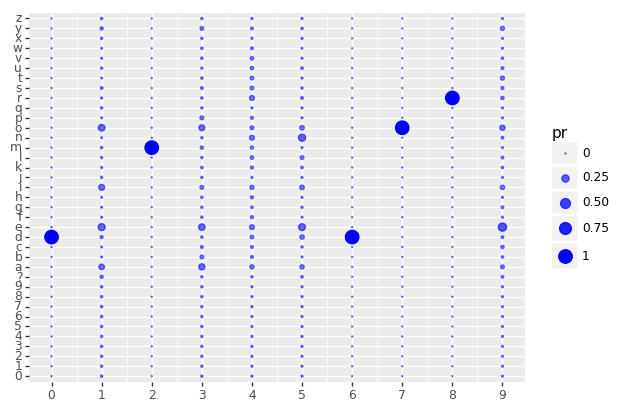

<ggplot: (-9223372029311057569)>

In [46]:
p = ggplot(df)
p = p + geom_point(aes(x = 'i', y = 'u', size = 'pr', alpha = 'pr'), color = 'blue')
p = p + scale_x_continuous(name='',breaks=list(range(n)))
p = p + scale_y_discrete(name='', drop=False)
p = p + scale_alpha(range=(0.5, 1)) 
p = p + scale_size(range=(0, 5))
display(p)

## III. Finding the most probable outcome 

The most naive way to compute the sequence that maximises the posterior probability is to compute posterior probability

\begin{align*}
p[\boldsymbol{x}|\color{red}{\mathsf{evidence}}]\propto\Pr[\color{red}{\mathsf{evidence}}|\boldsymbol{x}]\cdot\Pr[\boldsymbol{x}]
\end{align*}

where 
* the probability $\Pr[\color{red}{\mathsf{evidence}}|\boldsymbol{x}]$ is a zero-one indicator that shows whether $\color{red}{\mathsf{evidence}}$ is compatible with $\boldsymbol{x}$ 
* the probability $\Pr[\boldsymbol{x}]$ is the probability assigned by Markov Chain

This is obviusly infeasible. However, we can iteratively prolong candidate sequences:
* For each position we will find the most probable subsequence ending with all possible outcomes.
* For the next position we must just prolong the set of candidate sequences found the previous position. 
* We can always drop sequences that are incompatible with the evidence.

In [47]:
max_pr = [None] * n
prev_letter = [None] * n

### Initialisation

As the first observation is known there is only one compatible sub-sequence. 

In [48]:
max_pr[0] = Series(0, index = LetterType.categories)
max_pr[0]['d'] = 1 

In [49]:
max_pr[0]

a    0
b    0
c    0
d    1
e    0
f    0
g    0
h    0
i    0
j    0
k    0
l    0
m    0
n    0
o    0
p    0
q    0
r    0
s    0
t    0
u    0
v    0
w    0
x    0
y    0
z    0
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
?    0
dtype: int64

### Iterative update rule

As you can quess $\pi_{i+1}^*(v)=\max_u \pi_{i}^*(u)\cdot \alpha[u,v]$ if $x_{i+1}$ is unknown and $\pi_{i+1}^*(v)=\max_u \pi_{i}^*(u)\cdot \alpha[u,v]\cdot [v=x_{i+1}]$ otherwise. 

In [53]:
for letter in LetterType.categories.values:
    max_pr[0] * alpha.loc[:,letter]


In [56]:
probs = max_pr[0] * alpha.T
probs

,0,1,2,3,4,5,6,7,8,9,...,q,r,s,t,u,v,w,x,y,z
u2,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
for i in range(n-1):
    
    probs = max_pr[i] * alpha.T
    prev_letter[i + 1] = probs.idxmax(axis=1)
    max_pr[i + 1] = probs.max(axis=1)
    if x[i+1] != '-':
        max_pr[i + 1].loc[max_pr[i + 1].index != x[i+1]] = 0   

Now that we have computed candidates for the entire sequence, we can choose the maximal and go backwards to recover the corresponding assignment.

In [58]:
xmax = [None] * n
xmax[n - 1] = max_pr[9].idxmax()

for i in reversed(range(1,n)):
    xmax[i - 1] = prev_letter[i][xmax[i]]

In [282]:
xmax

['d', 'e', 'm', 'e', 'r', 'e', 'd', 'o', 'r', 'e']

### Visualisation

Lets find the maximal values of marginal posterior probabilities.

In [59]:
pdf = df.groupby(['i']).apply(lambda df: df.loc[df['pr'].idxmax()])
pdf

,u,i,pr
i,,,
0,d,0,1.000000
1,e,1,0.226907
2,m,2,1.000000
3,e,3,0.193854
4,r,4,0.094400
5,n,5,0.234895
6,d,6,1.000000
7,o,7,1.000000
8,r,8,1.000000


Lets mark the maximal path separately

In [60]:
mdf = DataFrame({'i': list(range(n)), 'xmax':xmax}).assign(xmax = lambda df: df['xmax'].astype(LetterType))

/anaconda3/envs/machine-learning/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


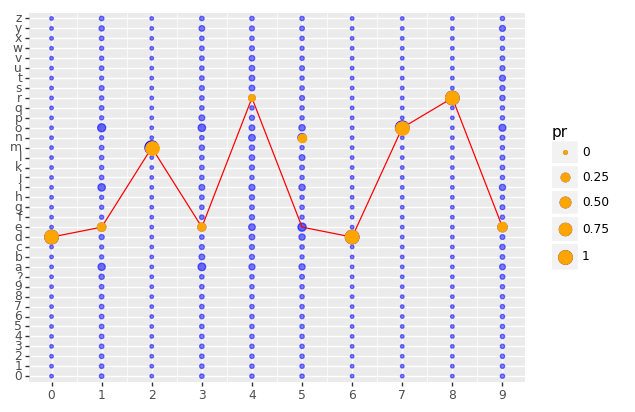

<ggplot: (7544197170)>

In [61]:
p = ggplot(df)
p = p + geom_point(aes(x = 'i', y = 'u', size = 'pr', alpha = 'pr'), color = 'blue')
p = p + geom_line(aes(x = 'i', y = 'xmax'), group=1, color="red", data = mdf)
p = p + geom_point(aes(x = 'i', y = 'u', size = 'pr'), color = 'orange', data = pdf) 
p = p + scale_x_continuous(name='',breaks=list(range(n)))
p = p + scale_y_discrete(name='', drop=False)
p = p + scale_alpha(range=(0.5, 1)) 
p = p + scale_size(range=(1, 5))
display(p)

# Homework

## 1.1 Function for imputing missing characters (<font color ='red'>1p</font>)

Define a function `impute_characters_1(x:str)` that imputes missing characters in words using belief propagation and outputs the last figure showing marginal posterior distributions for each location and maximum aposteriori estimate.
Test it on four different words with missing characters. 

## 1.2 Position dependent imputation (<font color='red'>1p</font>)

The example given above assumed that transitions probabilities $\Pr[x_{i+1}|x_i]$ are the same for all positions. The latter is not true as vowels and consonants are usually interleaved in the text.
Download a reasonably large text collection, for instance you can use freely available books form 
[Project Gutenberg](http://www.gutenberg.org) or some news corpora. Split the text into words and train transition matrices for each location separately. Formulae for maximum likelihood and Laplace smoothing are analogous but now location specific.
Define a function `impute_characters_2(x:str)` and compare its output with `impute_characters_2(x:str)`. To make fair comparison you must train both on the same data.

## 1.3 Higher order Markov chain for imputing* (<font color='red'>2p</font>)

In higher order Markov chain several position in the past are needed to fix the probability, i.e. the chain is defined through probabilities $\Pr[x_{i+m}|x_{i+m-1},\ldots,x_{i}]$.
This can be still modelled as an ordinary Markov chain by increasing the state space.
Let $\boldsymbol{s}_i=(x_{i+m-1},\ldots, x_{i})$ be the new statespace. Then the update rule is as follows

\begin{align*}
\Pr[\boldsymbol{s}_{i+1}|\boldsymbol{s}_i]=
\begin{cases}
\Pr[x_{i+m}|x_{i+m-1},\ldots,x_{i}], & \text{if } \boldsymbol{s}_{i+1}[j+1]=\boldsymbol{s}_{i}[j] \text{ for } j\in\{0,\ldots, m-2\}\\
0, &\text{otherwise}
\end{cases}
\end{align*}

As a result, you can reuse the belief propagation code from previous exercises. The only thechnical difference is that the beliefs and transition probabailities are shaped as multidimensional arrays and you need tensor operations to quickly compute the effect of marginalisation.   

Train second order Markov model on the same dataset as in the previus exercise and define a function `impute_characters_3(x:str)` and compare its output with previous imputing functions.

## 1.4 Language detection with Markov chains (<font color='red'>1p</font>)

Use files `est_training_set.csv` and `eng_training_set.csv` in the directory `data` to learn model parameters $\alpha$ and $\beta$ for homogenous Markow chains. Visualise the parameter set as it was done above. Interpret results.

Put these parameters into the formal model to compute probabilities

\begin{align*}
      p_1 &=\Pr[word|\mathsf{Estonian}]\\
      p_2 &=\Pr[word|\mathsf{English}]
\end{align*}

and then use Bayes formula

\begin{align*}
 \Pr[\mathsf{Estonian}|word]
 =\frac{\Pr[word|\mathsf{Estonian}]\Pr[\mathsf{Estonian}]}{\Pr[word]}
\end{align*}
to guess the language of a word on test samples `est_test_set.csv` and `eng_test_set.csv`.
Why the procedure does not work if you use maximum likelihood estimates for the parameters? 

**Hint:** The number of samples is not the problem. You can assume that there are enough samples to estimate all parameters with high accuracy. The same problem could have manifested even if there would have been millions of word examples.

In [3]:
%config IPCompleter.greedy=True